In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from mpmath import *
from mpl_toolkits import mplot3d
import plotly.express as px
import plotly.graph_objects as go

In [2]:
class Lightning_3D:

  # Initial values
  def __init__(self, name):
    self.name = name
    self.I = None          # Amperage [kA]  
    self.R = None          # Lightning jump distance [m]
    self.A = None          # ?
    self.alpha = None      # ?
    self.fi = None         # Next local jump coordinates 
    self.vartheta = None   # Next local jump coordinates
    self.L_class = None    # Lightning class
    self.h = None
    print(f'Lightning simulation: {self.name}')
    self.data = {}  

  # [Unfinished] When initianing multiple strikes, you can calculate the probability density. TODO: need of more physical explanation (I need that too)
  def generateProbabilityDensityFunction(self):
    pass
    u_0 = (math.log(self.I) - math.log(I_mu)) / (math.sqrt(2) * sigma_log) 
    erfc_u0 = 1 - ((2/math.sqrt(math.pi)) * nsum(lambda n: (-1**n * u_0**(2*n + 1)) / (math.factorial(n) * (2*n + 1)), [0, inf]))
    P_plus_minus_I = 0.5 * erfc_u0
    P_I = 0.9 * P_plus_minus_I + 0.1 * P_plus_minus_I 
    return P_I

  def generatePeakValue(self, i_class):
    self.I = [3, 200] # kA
    N_c = 15
    i = i_class
    r = np.random.uniform(0, 1)
    delta_I = (self.I[1] - self.I[0]) / N_c
    i_I_min = self.I[0] + (i - 1) * delta_I
    i_I_max = i_I_min + delta_I
    I_PeakValue = i_I_min + r * (i_I_max - i_I_min) 
    #print(f'Current class = {i}. I = [{i_I_min:.2f} – {i_I_max:.2f}]. Peak value = {I_PeakValue:.2f}')
    return I_PeakValue

  # def determinedLightningStrikesClass(self):
  #   pass

  def intersection(self, x, y, z):
    Point_1 = [x[-2], y[-2], z[-2]]
    Point_2 = [x[-1], y[-1], z[-1]]

    p = -(Point_1[2]/(Point_2[2] - Point_1[2]))

    Intersection_x = (Point_2[0] - Point_1[0])*p + Point_1[0]
    Intersection_y = (Point_2[1] - Point_1[1])*p + Point_1[1]
    return Intersection_x, Intersection_y

  def dataToPandas(self, x, y, z, i):
    self.data[f'x_{i}'] = x
    self.data[f'y_{i}'] = y
    self.data[f'z_{i}'] = z

  def evoliution(self, i_class, strike_id):
    bolt_number = 0
    a = 0
    b = 0
    h = 2000
    A = 10
    alpha = 0.65
    R = A + self.generatePeakValue(i_class)**alpha 

    self.x_PositionData = [a]
    self.y_PositionData = [b]
    self.z_PositionData = [2000]
    iteration = 0
    i = []

    while h > 0:
      u_jump = np.random.uniform(0, 1)
      phi = u_jump * 2 * math.pi
      vartheta = (u_jump + 1) * (math.pi / 2)

      x_j = self.x_PositionData[iteration] + (R * math.sin(vartheta) * math.cos(phi))
      self.x_PositionData.append(x_j)

      y_j = self.y_PositionData[iteration] + (R * math.sin(vartheta) * math.sin(phi))
      self.y_PositionData.append(y_j)

      z_j = self.z_PositionData[iteration] + (R * math.cos(vartheta))
      self.z_PositionData.append(z_j)
      h -= h - z_j

      # Finding intersection point between line and plane xy at z=0.
      
      if z_j < 0:

        # Changind the last point to intersection point z=0
        Inter_x, Inter_y = self.intersection(self.x_PositionData,
                                             self.y_PositionData,
                                             self.z_PositionData)

        self.x_PositionData[-1] = Inter_x
        self.y_PositionData[-1] = Inter_y
        self.z_PositionData[-1] = 0

      i.append(iteration)
      iteration += 1

    #print('Jump count:', iteration)

    self.dataToPandas(self.x_PositionData, self.y_PositionData, self.z_PositionData, strike_id)

  # default: strikes=1
  def MultiEvolution(self, i_class, strikes=1):
    assert strikes >= 1, f"There can't be a strike number lower than 1, your choise was: {strikes}"
    print(strikes)
    strikeNumber = strikes
    i = 1

    if strikeNumber == 1:
      self.evoliution(i_class, strike_id=1)

    else:
      while i < strikeNumber+1:
        self.evoliution(i_class, strike_id=i)
        i += 1
       
    df = pd.DataFrame.from_dict(self.data, orient='index')
    df = df.transpose()
    df.to_csv('results.csv', index=False)

  def plot(self, strike):
    result = pd.read_csv('results.csv')
    
    x_p = result[f'x_{strike}']
    y_p = result[f'y_{strike}']
    z_p = result[f'z_{strike}']

    fig = go.Figure(data=go.Scatter3d(x=x_p, y=y_p, z=z_p, marker=dict(size=2, color=z_p, colorscale='plasma'), line=dict(color='black',width=2)))
    fig.show()

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(x_p, z_p)
    plt.xlabel('x [m]')
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(y_p, z_p)
    plt.xlabel('y [m]')
    plt.tight_layout()

In [3]:
np.random.seed(2)
n = 1000
Ly = Lightning_3D(name='Your model 1.0')
Ly.MultiEvolution(i_class=15, strikes=n)

Lightning simulation: Your model 1.0
1000


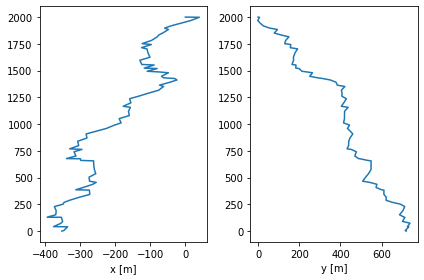

In [4]:
Ly.plot(strike=1)

In [5]:
result = pd.read_csv('results.csv')

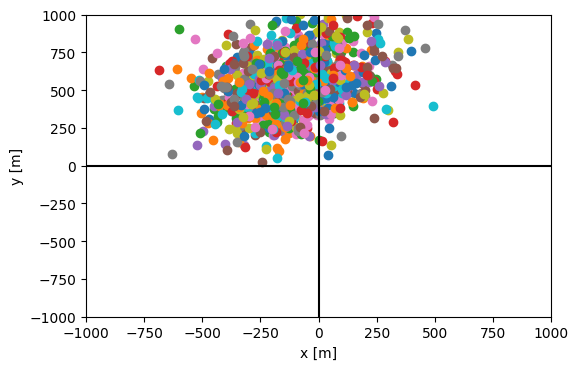

In [6]:
i = 1
plt.figure(dpi=100)
while i < n+1: 
  plt.scatter(result[f'x_{i}'].dropna().iat[-1], result[f'y_{i}'].dropna().iat[-1])
  plt.xlim(-1000, 1000)
  plt.ylim(-1000, 1000)
  plt.xlabel('x [m]')
  plt.ylabel('y [m]')
  i += 1

plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')